<a href="https://colab.research.google.com/github/allanbispo/Redes-Neurais-CESAR-School/blob/2023.02/apsb_Projeto_Final_da_Disciplina_RNA_DL_v3_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Projeto Final da Disciplina**

## **CESAR SCHOOL**
* Pós-graduação em Engenharia e Análise de Dados - 2023.2
* **Disciplina: RNA e Deep Learning**
* Professor: **Vitor Casadei**
* Aluno: **Allan Bispo** - apsb@cesar.school
* **`Link do Dataset Escolhido`**:
   * Arabic Handwritten Characters Dataset (https://www.kaggle.com/datasets/mloey1/ahcd1) - Parecido com MNIST

## Apresentação do Dataset

**O objetivo desse dataset é trazer um conjunto de imagens dos caracteres do alfabeto árabe. Esse alfabeto tem 28 algarismos e o dataset tem 16800 amostras com 1024 features e label.**

## Importando as bibliotecas

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

##(i) Carregamento do dataset e manipulações com os dados

### Carregando a base de dados de treino e teste
  * Os dados disponíveis no Kaggle já estão divididos, então o loading será direto.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
train_image = pd.read_csv("/content/drive/MyDrive/RNA_DeepL/csv_arabic/csvTrainImages 13440x1024.csv", header=None)
train_label = pd.read_csv("/content/drive/MyDrive/RNA_DeepL/csv_arabic/csvTrainLabel 13440x1.csv", header=None)
test_image = pd.read_csv("/content/drive/MyDrive/RNA_DeepL/csv_arabic/csvTestImages 3360x1024.csv", header=None)
test_label = pd.read_csv("/content/drive/MyDrive/RNA_DeepL/csv_arabic/csvTestLabel 3360x1.csv", header=None)

In [24]:
# Verificando o shape dos arquivos:

print('Shape do train_image: ',train_image.shape)
print('Shape do train_label: ',train_label.shape)
print('Shape do test_image: ',test_image.shape)
print('Shape do test_label: ',test_label.shape)

Shape do train_image:  (13440, 1025)
Shape do train_label:  (13440, 1)
Shape do test_image:  (3360, 1025)
Shape do test_label:  (3360, 1)


* `Pelo quantitativo o split do dataset foi 80/20, ou seja 20% das amostras foram dedicadas para treino.`

In [25]:
train_image.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
12862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25
8619,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
5824,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [26]:
test_label.sample(5)

,0
58,2
1135,8
2797,27
2734,24
842,2


In [27]:
train_label.describe()

,0
count,13440.000000
mean,14.500000
std,8.078048
min,1.000000
25%,7.750000
50%,14.500000
75%,21.250000
max,28.000000


In [28]:
test_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Columns: 1025 entries, 0 to label
dtypes: int64(1025)
memory usage: 26.3 MB


In [29]:
# Verificando valores ausentes.

print(sum(train_image.isnull().sum()),' valores ausentes em train_image.')
print(sum(train_label.isnull().sum()),' valores ausentes em train_label.')
print(sum(test_image.isnull().sum()),' valores ausentes em test_image.')
print(sum(test_label.isnull().sum()),' valores ausentes em test_label.')

0  valores ausentes em train_image.
0  valores ausentes em train_label.
0  valores ausentes em test_image.
0  valores ausentes em test_label.


### Manipulação dos Dados
  * Foi necessário adicionar os 'label' ao conjunto de imagens para ter um treinamento e avaliação mais precisos do alfabeto árabe.
  * Criou-se uma classe para carregar, transformar e retornar as imagens e seus rótulos já com reshape 32x32.
  * Fruto das diversas tentativas de melhoria adotou-se a técnica de 'Data Augmentation', para o modelo 'ter' mais dados para treino. Usou-se métodos de rotação e translação das imagens.

In [30]:
# Adiciona os 'label' ao dataframe
train_image['label'] = train_label
test_image['label'] = test_label
print(train_image.shape)

(13440, 1025)


In [31]:
# Classe para load e transform, fazendo reshape para 32x32 (1024 pixels)
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data.iloc[index, self.data.columns != 'label'].values.astype(np.uint8).reshape(32, 32)
        label = self.data.iloc[index, -1] - 1

        # Convert numpy array to PIL image
        image = Image.fromarray(image)

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [32]:
# Data Augmentation
transform = transforms.Compose([
    transforms.RandomRotation(10),  # Rotação randômica das imagens (10 graus)
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Translação randômica das imagens
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [33]:
# Criação dos datasets e data loaders
train_image_dataset = ImageDataset(train_image, transform)
train_loader = DataLoader(train_image_dataset, batch_size=32, shuffle=True)
test_image_dataset = ImageDataset(test_image, transform)
test_loader = DataLoader(test_image_dataset, batch_size=32, shuffle=False)

### Visualização dos Dados

In [40]:
train_image.shape

(13440, 1025)

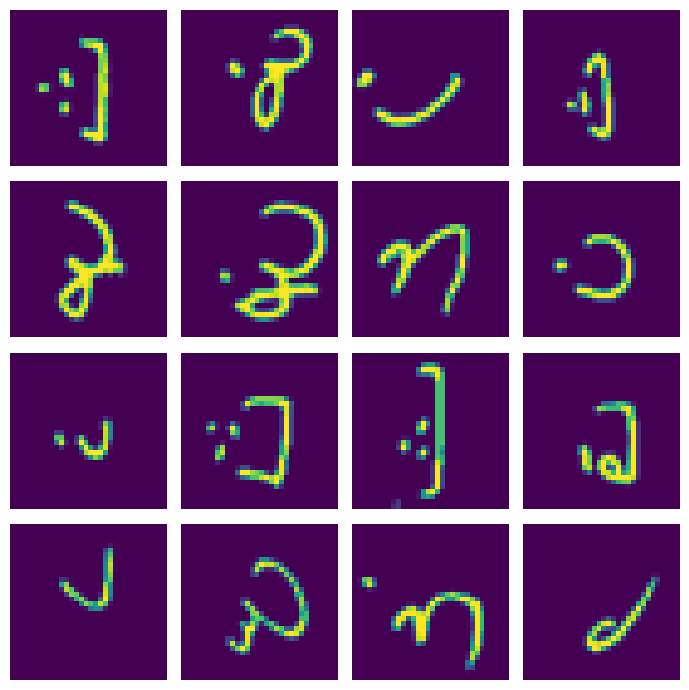

In [50]:
# Visualizando uma amostra dos dados de teste

random_indices = np.random.choice(len(train_image), 16, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(7, 7))

for i, idx in enumerate(random_indices):
    image = train_image.iloc[idx, train_image.columns != 'label'].values.astype(np.uint8).reshape(32, 32)
    label = train_image.iloc[idx, -1]

    image = Image.fromarray(image)

    ax = axes[i // 4, i % 4]
    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
plt.show()

##(ii) Definição do modelo de redes neurais utilizada para treinar o modelo

* `Após diversas tentativas de se obter um desempenho melhor, chegou-se ao modelo abaixo:`
* `Devido a complexidade dos caracteres árabes, usou-se muitos nós de rede e 3 camadas ocultas.`
* `Os testes mostraram que mais de 3 camadas ocultas resultava em performance pior, e também o uso de ReLU tradional não surtia efeito ótimo.`
* `A rede inicia com 32x32 nós de entrada (1024 pixels das imagens) e tem como saída 28 nós, perfazendo todos os algarismos do alfabeto árabe.`
* `Usou-se Leaky_relu como função de ativação para lidar com as limitações do ReLU (dead neuron), associada com batch de normalização para estabilizar mais o treino.`
* `Para regularização testou-se dropout de 0.2, 0.3 e 0.5, sendo 0.3 o de melhor resultado.`


In [54]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        hidden_3 = 256

        self.fc1 = nn.Linear(32*32, hidden_1)
        self.bn1 = nn.BatchNorm1d(hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.bn2 = nn.BatchNorm1d(hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.bn3 = nn.BatchNorm1d(hidden_3)
        self.fc4 = nn.Linear(hidden_3, 28)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(-1, 32*32)  # Flatten the input
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)  # Apply dropout
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)  # Apply dropout
        x = F.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)  # Apply dropout
        output = self.fc4(x)  # Output layer
        return output

model = Net()
print(model)

Net(
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=256, out_features=28, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


##(iii) Treinamento do modelo

* `Como poderá ser visto no gráfico 60 épocas já dá uma estacionariedade aos resultados. O learning rate teve que ser bem baixo para conseguir melhores resultados.`
* `O otimizador Adam foi substituído pelo AdamW para obeter um training loss melhorado, com decaimento de peso.`
* `Ao learning rate foi adotado scheduler para melhor ajuste durante o treino, ficando o CosineAnnealingLR como o tipo de melhor desempenho nos testes.`
* `A função de perda foi a de entropia, já consolidada como mais eficiente.`

In [55]:
num_epochs = 60
learning_rate = 0.0005

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

* `O laço de treinamento foi incrementado para contabilizar as informações de perda e acurácia, para fins de construção do gráfico de desempenho.`
* `À época que o treino é feito faz-se o teste de avaliação e armazenou-se para fins também de plotting.`
* `A cada época se zera os gradientes do otimizador, faz-se a predição, cálculo da perda, backpropagation das perdas para atualização dos pesos do otimizador.`
* `No modelo de avaliação se compara o predito com os 'label'.`

In [56]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

###### LAÇO DE TREINAMENTO ######
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the weights

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_corrects.double() / total_samples
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc.item())

    # Print epoch loss and accuracy
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%')

    # Step the learning rate scheduler
    scheduler.step()

    ###### LAÇO DE AVALIAÇÃO (em cada época) ######
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = correct / total
    test_acc_list.append(test_acc)
    print(f'Test Accuracy after Epoch {epoch + 1}: {test_acc * 100:.2f}%')

Epoch [1/60], Loss: 2.5860, Accuracy: 21.79%
Test Accuracy after Epoch 1: 38.45%
Epoch [2/60], Loss: 1.9997, Accuracy: 34.91%
Test Accuracy after Epoch 2: 44.61%
Epoch [3/60], Loss: 1.7879, Accuracy: 40.38%
Test Accuracy after Epoch 3: 50.48%
Epoch [4/60], Loss: 1.6358, Accuracy: 44.40%
Test Accuracy after Epoch 4: 55.36%
Epoch [5/60], Loss: 1.5281, Accuracy: 48.21%
Test Accuracy after Epoch 5: 59.49%
Epoch [6/60], Loss: 1.4665, Accuracy: 50.16%
Test Accuracy after Epoch 6: 60.95%
Epoch [7/60], Loss: 1.4133, Accuracy: 51.70%
Test Accuracy after Epoch 7: 64.05%
Epoch [8/60], Loss: 1.3587, Accuracy: 52.97%
Test Accuracy after Epoch 8: 66.88%
Epoch [9/60], Loss: 1.3108, Accuracy: 54.73%
Test Accuracy after Epoch 9: 65.24%
Epoch [10/60], Loss: 1.2718, Accuracy: 55.71%
Test Accuracy after Epoch 10: 69.02%
Epoch [11/60], Loss: 1.2489, Accuracy: 56.71%
Test Accuracy after Epoch 11: 67.89%
Epoch [12/60], Loss: 1.2252, Accuracy: 57.49%
Test Accuracy after Epoch 12: 70.33%
Epoch [13/60], Loss: 1

##(iv) Análise da performance

* `Gráfico aprentando as perdas e a acurácia de treino e teste à cada época da rede.`

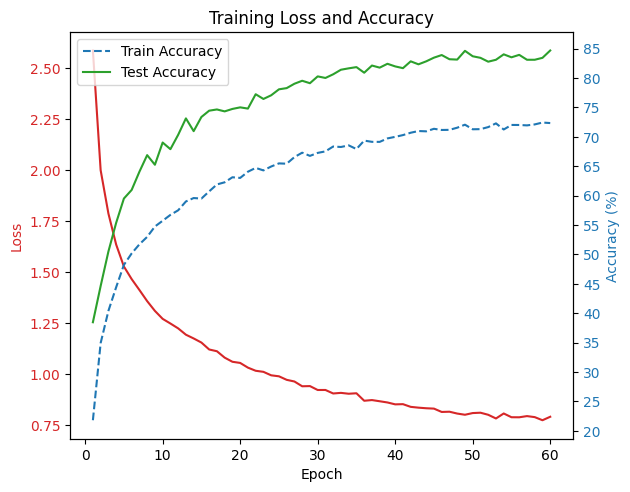

In [57]:
# Plotting Loss and Accuracy
epochs = range(1, num_epochs + 1)

fig, ax1 = plt.subplots()

# Plotting the loss
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, train_loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis to plot the accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(epochs, [acc * 100 for acc in train_acc_list], label='Train Accuracy', color=color, linestyle='dashed')
ax2.plot(epochs, [acc * 100 for acc in test_acc_list], label='Test Accuracy', color='tab:green')
ax2.tick_params(axis='y', labelcolor=color)

ax2.set_yticks(range(20, 86, 5))

fig.tight_layout()
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()

* `Matriz de confusão mostrando a dispersão entre os caracters preditos e reais do alfabeto árabe.`

<Figure size 1800x800 with 0 Axes>

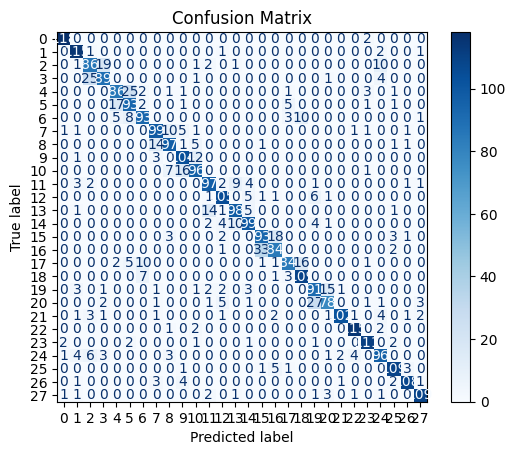

In [64]:
# Confusion Matrix

model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

##Conclusão

* `Ao escolher o dataset do alfabeto manuscrito árabe, o que chamou atenção foi que todos os códigos disponíveis no Kaggle usavam CNN. Somente após botar para rodar os treinamentos e testes pude finalmente entender o por que.`
* `As imagens com as letras manuscritas do árabe são muito complexas, então o não uso de redes convolucionais restrigiu a capacidade do modelo ser melhor treinado.`
* `Com isso vários testes foram feitos, começando com o básico, nn.Linear com 1 camada somente, depois multiplas camadas e vários ajustes de funções de ativação, hyperparameters, conforme demonstrado acima.`
* `Mesmo não usando CNN consegui-se acurácio de treino de 72% e de teste 84%, o que sugere uma rede ainda underfitted, havendo margem para melhoria sem risco de overfitting.`
* `Conforme pode ser visto no gráfico de perda e acurácia, com mais épocas ainda poderia-se conseguir uma melhora, todavia o tempo de processamento é alto para um ganho adiconal marginal.`